# Approach B . Complex Valued Deep Learning- Heart Sounds Scalograms

In [1]:
from torchvision import datasets, transforms
import torch
import random
import numpy as np
#import torch.nn as nn
import torchcomplex.nn.functional as F
import torch.optim as optim
import torchcomplex.nn as cnn
import torch.nn as nn
from torch.utils import data  
import os 
semilla = 0
torch.manual_seed(semilla)
np.random.seed(semilla)
os.listdir()
random.seed(semilla)
from sklearn.metrics import f1_score
from datetime import date
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

In [2]:

data_dir = os.path.join(os.getcwd(),'./Scalograms/') # path of the train images
#test_dir = os.path.join(os.getcwd(),'/home/evida/Documentos/Tesis_Melanoma/Melanoma_thesis_2021/test/') # path of the test images

# Number of classes in the dataset
num_classes = 2

# input size, ???
input_size = 224
# Images transform and normalization
train_t = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        #transforms.RandomResizedCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_t = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# load the dataset
train_set = datasets.ImageFolder(data_dir, train_t)
#test_set = datasets.ImageFolder(test_dir, test_t)

train_loader_1 = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)


In [3]:
print(len(train_loader_1.dataset)) # number of samples
print(len(train_loader_1)) # number of batches

#print(len(test_loader.dataset))

2282
286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


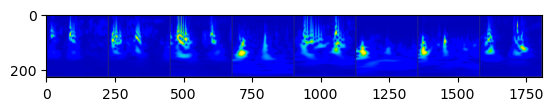

tensor(0) tensor(0) tensor(1) tensor(1)
torch.Size([8, 3, 224, 224])


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img * 0.456 + 0.224     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader_1)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))
print(images.size())


In [5]:
class Mario_NetC3(nn.Module):
    def __init__(self):
        super(Mario_NetC3, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = cnn.Conv2d(3, 48, 5)
        self.conv2 = cnn.Conv2d(48, 24, 3)
        self.conv3 = cnn.Conv2d(24, 32, 3)
        # an affine operation: y = Wx + b
        self.avgpool = cnn.AvgPool2d(kernel_size=(2, 2))
        #self.avgpool2 = cnn.AvgPool2d(kernel_size=(2,2))
        self.fc1 = cnn.Linear(32*2*2650*1, 1200)
        self.fc2 = cnn.Linear(1200, 500)
        # NOTE!  we do not use the Gaussian connections for simplicity.
        self.fc3 = cnn.Linear(500, 2)
    
    # Connect layers, define activation functions
    def forward(self, x):
        # avg pooling over a (2, 2) window
        x = self.conv1(x)
        x = self.avgpool(F.crelu(x))
        # If the size is a square you can only specify a single number
        x = self.conv2(x)
        x = self.conv3(x)
        #print(x.shape)
        #x = self.avgpool2(F.crelu(x))
        # Flat x for fc
        x = x.view(-1, self.num_flat_features(x))
        #print(x.shape)
        x = F.crelu(self.fc1(x))
        x = F.crelu(self.fc2(x))
        x = torch.abs(self.fc3(x))
        #x = np.real(self.fc3(x))
        return x
    
    def num_flat_features(self, x): # To see dimensions of layers
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

model = Mario_NetC3()
print(model)

Mario_NetC3(
  (conv1): Conv2d(
    3, 48, kernel_size=(5, 5), stride=(1, 1)
    (weight): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 48x3x5x5]
        (1): Parameter containing: [torch.FloatTensor of size 48x3x5x5]
    )
    (bias): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 48]
        (1): Parameter containing: [torch.FloatTensor of size 48]
    )
  )
  (conv2): Conv2d(
    48, 24, kernel_size=(3, 3), stride=(1, 1)
    (weight): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 24x48x3x3]
        (1): Parameter containing: [torch.FloatTensor of size 24x48x3x3]
    )
    (bias): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 24]
        (1): Parameter containing: [torch.FloatTensor of size 24]
    )
  )
  (conv3): Conv2d(
    24, 32, kernel_size=(3, 3), stride=(1, 1)
    (weight): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 32x2

In [6]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
loss_f = nn.CrossEntropyLoss(reduction = 'mean')

In [7]:
def train(train_loader, model, optimizer, log_interval, epoch, criterion):
    model.train() # Sets the module in training mode.
    for batch_idx, (inputss, labels) in enumerate(train_loader, 0): # get the inputs. Start from index 0.
        
        #inputs=torch.fft.fft2(inputss)
        inputs=torch.fft.rfft(inputss)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        
        # print statistics
        #if batch_idx % log_interval == (log_interval-1):
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(inputs), len(train_loader.dataset),
           #     100. * batch_idx / len(train_loader), loss.item()))
            
def test(test_loader, model, criterion):
    
    lne_2 = 20
    lne_1 = 170
    model.eval() # Sets the module in evaluation mode.
    test_loss = 0 # loss compute by criterion
    correct = 0 # for computing accurate
    f1 = 0
    b_acc = 0
    # `with` allows you to ensure that a resource is "cleaned up" 
    # when the code that uses it finishes running, even if exceptions are thrown.
    with torch.no_grad(): # It will reduce memory consumption for computations that would otherwise have requires_grad=True.
        for inputss, labels in test_loader:
            inputs=torch.fft.rfft(inputss)
            outputs = model(inputs.to(device))
            test_loss += criterion(outputs.to(device), labels.to(device)).item() # sum up batch loss
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.to(device).view_as(pred)).sum().item()
            ##############################
            
            f1 += f1_score(labels.cpu(), pred.cpu(), average='micro')
            
            b_acc += balanced_accuracy_score(labels.cpu(), pred.cpu())
            #######################################################
   
   
    test_loss /= lne_2 
    acc = correct / lne_1
    test_loss_array.append(test_loss)
    acc_array.append(acc)
   
    ####################################
    #print("f1:")
    f1 /= lne_2
    f1_array.append(f1)
    #print(f1)
    #print("b_acc:")
    b_acc /= lne_2
    b_acc_array.append(b_acc)
    #print(b_acc)
    ##############################
    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
     #   test_loss, correct, len(test_loader.dataset),
      #  100. * correct / len(test_loader.dataset)))

In [8]:
import copy
use_cuda = torch.cuda.is_available()
print(use_cuda)

device = torch.device("cuda" if use_cuda else "cpu")
device = 'cuda:0'
model_base = Mario_NetC3().to(device)
model_input_base = copy.deepcopy(model_base)
del model_base
# Insert "data, target = data.to(device), target.to(device)" in train and test.


True


In [9]:
#############################################################################
semilla = 0
torch.manual_seed(semilla)
np.random.seed(semilla)
os.listdir()
random.seed(semilla)

In [10]:
import numpy as np
arr = np.arange(2282)
np.random.shuffle(arr)

In [11]:
criterion = loss_f
log_interval = 200
epoch = 5

def crossvalid(model_input_base=None,criterion=None,optimizer=None,dataset=None,k_fold=10):
    
      
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        ####################################################
        model = copy.deepcopy(model_input_base)
        batch_size = 8 #### ojo aqui va 32
        shuffle_state = True
        #####################################################
        
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        #print(trll)
        #print(trlr)
        #print(vall)
        #print(valr)
        #print(trrl)
        #print(trrr)
        
        train_left_indices = list(range(trll,trlr))
        #print(train_left_indices)
        train_right_indices = list(range(trrl,trrr))
        #print(train_right_indices)
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
  ############################################################################################
        train_indices_ = []
        val_indices_ = []
        for i in train_indices:
            train_indices_.append(arr[i])
        for i in val_indices:
            val_indices_.append(arr[i])


##############################################################################################
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices_)
        #print(len(train_set))
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices_)
        

        
        train_loader_ = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=shuffle_state, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=shuffle_state, num_workers=4)
        train_acc = train(train_loader_, model, optimizer, log_interval, epoch, criterion)
        test(val_loader, model, criterion)
       
    
    return train_acc
acc_array = []
f1_array = []
b_acc_array = []
test_loss_array = []
tr_acc = crossvalid(model_input_base,criterion,optimizer,train_set)



/home/evida/anaconda3/envs/deep_complex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/evida/anaconda3/envs/deep_complex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/evida/anaconda3/envs/deep_complex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/evida/anaconda3/envs/deep_complex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [12]:
import pandas as pd
metricas = np.zeros([4,10])
metricas[:][0] = np.asarray(acc_array).ravel()
metricas[:][1] = np.asarray(b_acc_array).ravel()
metricas[:][2] = np.asarray(f1_array).ravel()
metricas[:][3] = np.asarray(test_loss_array).ravel()
df = pd.DataFrame(metricas.transpose())
df.to_csv('Results_heart_sounds_20062022.csv')

In [13]:
df

,0,1,2,3
0,0.782353,0.767917,0.84375,0.971661
1,0.782353,0.810536,0.84375,0.983410
2,0.682353,0.690417,0.73750,0.996449
3,0.782353,0.800060,0.85625,0.979485
4,0.735294,0.765119,0.80000,1.000737
5,0.770588,0.771667,0.83125,0.982371
6,0.717647,0.763452,0.78125,0.995956
7,0.747059,0.703214,0.79375,0.994991
8,0.788235,0.808690,0.86250,0.978294
9,0.823529,0.741071,0.88125,0.981581


In [26]:
acc = np.max(df.iloc[:,0])
torch.save(model.state_dict(), 'best_model_complex_'+'____'+str(acc)+'.h5')

In [19]:
acc

0.8235294117647058

In [ ]:
#the_model = TheModelClass(*args, **kwargs)
#the_model.load_state_dict(torch.load(PATH))